## 텍스트데이터분석 프로젝트

### 목차
#### 1. 데이터 수집
    - 1. 네이버자동차
    - 2. 다음자동차
#### 2. 데이터 전처리
    - 분석의도와 무관한 댓글 제거
    - 중복 댓글 제거
    - 불용어구
    - comment란이 빈 경우
#### 3. 단어 빈도
#### 4. 감성분석
#### 5. 주제분석

## 1. 데이터 수집
 - 네이버 자동차와 다음 자동차의 댓글을 사용하였다. 그중에서 국내차량브랜드 중 국내시판 모델을 대상으로 한다.

In [ ]:
from selenium import webdriver
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
dr = webdriver.Chrome('./chromedriver_win32/chromedriver')

#### 1-1) 네이버자동차
- 2021년 04월 18일 오전2시22분에 크롤링한 데이터를 분석에 사용하였다.

In [ ]:
urls = [["https://auto.naver.com/company/main.nhn?mnfcoNo=12&modelType=OS&order=0&importYn=N&lnchYY=-1&saleType=0", 'KIA'],
        ["https://auto.naver.com/company/main.nhn?mnfcoNo=16&modelType=OS&order=0&importYn=N&lnchYY=-1&saleType=0", 'HYUNDAI'],
        ["https://auto.naver.com/company/main.nhn?mnfcoNo=61321&modelType=OS&order=0&importYn=N&lnchYY=-1&saleType=0", 'GENESIS'],
        ["https://auto.naver.com/company/main.nhn?mnfcoNo=13&modelType=OS&order=0&importYn=N&lnchYY=-1&saleType=0", 'SSANGYONG'],
        ["https://auto.naver.com/company/main.nhn?mnfcoNo=15&modelType=OS&order=0&importYn=N&lnchYY=-1&saleType=0", 'SAMSUNG'],
        ]

In [ ]:
f = open('naver_review.csv','w')
f.write('maker,car,car_num,comment')
f.close()

In [ ]:
import pandas as pd
car_review = pd.read_csv('naver_review.csv',encoding='cp949')
car_review

In [ ]:
for u in range(len(urls)):
    dr.get(urls[u][0])
    #한페이지 차량정보, 총 15대
    cars = dr.find_elements_by_css_selector("div.model_ct ")
    nums = dr.find_elements_by_css_selector("div > div > a.model_name")
    #차량정보(제조사,이름,고유번호)
    car_info= []
    for i in range(len(cars)):
        car_info.append([f'{urls[u][1]}',cars[i].text.split('\n')[0].replace(' ',''),nums[i].get_attribute("href").split('=')[1]])
    
    for maker,c,num in car_info:
        dr.get(f'https://auto.naver.com/car/talk.nhn?yearsId={num}')
        time.sleep(0.5)
    
        #댓글 페이지 이동을 쉽게하기위해 마지막페이지부터 크롤링
        last = dr.find_element_by_css_selector("#comment_box_module > div > div.u_cbox_paginate > div > a.u_cbox_next.u_cbox_next_end")
        last.click()
        time.sleep(0.1)
    
        #마지막페이지 댓글 저장
        comments = dr.find_elements_by_css_selector("div.u_cbox_text_wrap span.u_cbox_contents")
        #time.sleep(0.1)
        for j in range(len(comments)):
            time.sleep(0.1)
            comment=comments[j].text.replace(",","")
            #견적요청 혹은 홍보와 관련된 댓글을 1차적으로 제외
            if '견적' in comment:
                continue
            elif '.com' in comment:
                continue
            elif '렌트' in comment:
                continue
            else:
                try:
                    f = open('car_review.csv','a')
                    f.write(f'\n{maker},{c},{num},{comment}')
                except:
                    continue
                f.close()
        n=1
        #앞으로 넘어가면서 댓글 저장
        while n!=0:
            length = len(dr.find_elements_by_css_selector("#comment_box_module > div > div.u_cbox_paginate > div > a"))
            #맨앞,이전,이후,맨뒤 버튼때문에 length에 조건을 둠
            if length==13:
                length-=2
            elif length==12:
                length-=1
            for i in range(length,1,-1):
                tag = f"#comment_box_module > div > div.u_cbox_paginate > div > a:nth-child({i})"

                if length==2:
                    tag = f"#comment_box_module > div > div.u_cbox_paginate > div > a:nth-child(1)"
                try:
                    page = dr.find_element_by_css_selector(tag)
                except:
                    break
                page.click()
                time.sleep(0.5)
                comments = dr.find_elements_by_css_selector("div.u_cbox_text_wrap span.u_cbox_contents")
            
                for j in range(len(comments)):
                    comment=comments[j].text.replace(",","")
                    #견적요청 혹은 홍보와 관련된 댓글을 1차적으로 제외        
                    if '견적' in comment:
                        continue
                    elif '.com' in comment:
                        continue
                    elif '렌트' in comment:
                        continue
                    else:
                        try:
                            f = open('naver_review.csv','a')
                            f.write(f'\n{maker},{c},{num},{comment}')
                        except:
                            continue
                        f.close()
                #1번 댓글을 보게되면 맨앞, 이전 버튼이 사라져서 해당 선택자가 없으면 n을 0으로 하고 while반복의 종료조건으로 둠
                try:
                    front = dr.find_element_by_css_selector("#comment_box_module > div > div.u_cbox_paginate > div > a.u_cbox_pre.u_cbox_pre_end > span.u_cbox_cnt_page")
                except:
                    n=0

#### 1-2) 다음자동차
- 2021년 04월 19일 오후6시15분에 크롤링한 데이터를 분석에 사용하였다.

In [ ]:
f = open('daum_review.csv','w')
f.write('score,comment')
f.close()

In [ ]:
url = ['https://auto.daum.net/newcar/model/m5pWKLBwz2p7', #현대 코나 F/L (1세대)
       'https://auto.daum.net/newcar/model/miqPAv9RvY3w', #현대 코나 하이브리드 F/L (1세대)
       'https://auto.daum.net/newcar/model/mi80000bxxy8', #현대 쏘나다 (8세대)
       'https://auto.daum.net/newcar/model/mul0002sMM2d', #현대 쏘나다 하이브리드 (8세대)
       'https://auto.daum.net/newcar/model/ma600020ppal', #현대 그랜저 F/L (6세대)
       'https://auto.daum.net/newcar/model/mab00021ppcw', #현대 그랜저 하이브리드 F/L (6세대)
       'https://auto.daum.net/newcar/model/mqa381027dvy', #현대 싼타페 F/L (4세대)
       'https://auto.daum.net/newcar/model/mi50000vKK32', #현대 펠리세이드 (1세대)
       'https://auto.daum.net/newcar/model/mmvn38WP51cm', #제네시스 G70 F/L (1세대)
       'https://auto.daum.net/newcar/model/mwbRY0KZ90pp', #제네시스 GV70 (1세대)
       'https://auto.daum.net/newcar/model/mlo0000eOOzs', #제네시스 G80 (3세대)
       'https://auto.daum.net/newcar/model/mw70000uKKdl', #제네시스 G90 (1세대)
       'https://auto.daum.net/newcar/model/mp8dbN6XDntm', #기아 K8 (1세대)
       'https://auto.daum.net/newcar/model/ma000079lliy', #기아 K7 F/L (2세대)
       'https://auto.daum.net/newcar/model/m9l0007flle5', #기아 K7 하이브리드 F/L (2세대)
       'https://auto.daum.net/newcar/model/m2wWKA9kEx9t', #기아 스팅어 F/L (1세대)
       'https://auto.daum.net/newcar/model/mm2rW5qZwM7t', #기아 카니발 (4세대)
       'https://auto.daum.net/newcar/model/mij00002kkw7', #기아 쏘렌토 (4세대)
       'https://auto.daum.net/newcar/model/m4x0000aOOma', #기아 쏘렌토 하이브리드 (4세대)
       'https://auto.daum.net/newcar/model/m829Q7zeWB4s', #르노삼성 SM6 F/L (1세대)
       'https://auto.daum.net/newcar/model/m0r00007kkav', #르노삼성 XM3 (1세대)
       'https://auto.daum.net/newcar/model/m9e0007hll5k', #르노삼성 QM6 F/L (1세대)
       'https://auto.daum.net/newcar/model/mapp2bqPBY35', #쌍용 렉스턴 F/L (2세대)
       'https://auto.daum.net/newcar/model/mvc1GK5r9El6', #쌍용 렉스턴 스포츠 F/L (2세대)
       'https://auto.daum.net/newcar/model/mvkaYJb89Eyi', #쌍용 렉스턴 스포츠 칸 F/L (2세대)
       'https://auto.daum.net/newcar/model/mvr0000all1u', #쌍용 티볼리 F/L (1세대)
       'https://auto.daum.net/newcar/model/m2v71DZA7Jpt', #쌍용 티볼리 에어 F/L (1세대)
       'https://auto.daum.net/newcar/model/mef00006xxn2', #쌍용 코란도 (4세대)
      ]

In [ ]:
for u in url:
    dr.get(u)
    time.sleep(0.05)
    while True:
        try:
            more = dr.find_element_by_css_selector("div.alex_more > button")
            more.click()
            time.sleep(0.05)
        except:
            break
    comments = dr.find_elements_by_css_selector('li > div > p')
    scores = dr.find_elements_by_css_selector("div.ratings")
    for i in range(len(comments)):
        comment = comments[i].text.replace(",","").replace("\n","")
        score = scores[i].text
        if '견적' in comment:
            continue
        elif '.com' in comment:
            continue
        elif '렌트' in comment:
            continue
        elif '딜러' in comment:
            continue
        else:
            try:
                f = open('daum_review.csv','a')
                f.write(f'\n{score},{comment}')
            except:
                continue
            f.close()

## 2. 데이터 전처리

In [2]:
import pandas as pd
#import pickle

In [3]:

naver = pd.read_csv('./naver_review_222.csv', encoding = 'cp949')
daum = pd.read_csv('./daum_review_0615.csv', encoding = 'cp949')


#### 분석 의도와 무관한 댓글 제거

In [5]:
delete = ['오토론', 'president', '딜러', '@네이버', '@naver', '@hanmail', 'band.us', '현금지원', '렌터', 'blog', '온라인']

In [6]:
idx = 0
idx_n = []
for i in range(len(naver.comment)):
    if any(d in naver.comment[i] for d in delete):
        idx_n.append(idx)
        idx+=1
    else:
        idx+=1
print(f'총 {len(idx_n)}개의 댓글 삭제')

총 88개의 댓글 삭제


In [7]:
idx = 0
idx_d = []
for i in range(len(daum.comment)):
    if any(d in daum.comment[i] for d in delete):
        idx_d.append(idx)
        idx+=1
    else:
        idx+=1
print(f'총 {len(idx_d)}개의 댓글 삭제')

총 2개의 댓글 삭제


In [8]:
naver = naver.query('index not in @idx_n').reset_index().drop(columns='index')
daum = daum.query('index not in @idx_d').reset_index().drop(columns='index')

In [9]:
#### 중복 댓글 제거

In [10]:
naver.drop_duplicates(subset=['comment'],inplace=True)
daum.drop_duplicates(subset=['comment'],inplace=True)

In [11]:
naver=naver.reset_index().drop(columns='index')
daum=daum.reset_index().drop(columns='index')

#### 불용어구

In [12]:
# https://shinminyong.tistory.com/4 참고 및 인용

import re

#이모티콘 제거
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

#분석에 어긋나는 불용어구 제외 (특수문자, 의성어)
han = re.compile(r'[ㄱ-ㅎㅏ-ㅣ!?></&|~+=,".\n\r#\ufeff\u200d]')

In [13]:
n=0
for i in naver.comment:
    tokens = re.sub(emoji_pattern,"",i)
    tokens = re.sub(han,"",tokens)
    naver.loc[n,'comment'] = tokens
    n+=1

In [14]:
n=0
for i in daum.comment:
    tokens = re.sub(emoji_pattern,"",i)
    tokens = re.sub(han,"",tokens)
    daum.loc[n,'comment'] = tokens
    n+=1

In [15]:
daum.comment[2435]

'LPG 모델 매우만족 실연비 97 정도 나옴'

#### 띄어쓰기 및 맞춤법 전처리
 - https://github.com/ssut/py-hanspell
 - 실행시간이 총 30분 정도로 이 과정을 거친 후 피클로 저장한 뒤 분석에 사용


In [16]:
!pip install git+https://github.com/ssut/py-hanspell.git

  Cloning https://github.com/ssut/py-hanspell.git to c:\users\junyoung\appdata\local\temp\pip-req-build-udd7xh3g
  Resolved https://github.com/ssut/py-hanspell.git to commit fdc6ca50c19f1c85971437a072d89d4e5ce024b8
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for py-hanspell: filename=py_hanspell-1.1-py3-none-any.whl size=4850 sha256=2af9764aaa9666755501c76e2f6161b366a4e6127977ff9e200bcb7d86d59a08
  Stored in directory: C:\Users\JUNYOUNG\AppData\Local\Temp\pip-ephem-wheel-cache-lxiqhwag\wheels\94\bc\ef\2cb90c305d609f8086489e7e1bd69f21e955118f26938609b7
Successfully built py-hanspell


  Running command git clone --filter=blob:none --quiet https://github.com/ssut/py-hanspell.git 'C:\Users\JUNYOUNG\AppData\Local\Temp\pip-req-build-udd7xh3g'


In [17]:
from hanspell import spell_checker

In [19]:
naver

,maker,car,car_num,comment
0,KIA,2021K8,144093,기아가 디자인 하나는 참 잘 뽑아
1,KIA,2021K8,144093,이거 엄청 좋을것 같네요 기대 됩니다
2,KIA,2021K8,144093,나와봐야안다 이쁘다 이상하다 호불호 사고싶다 돈이없다 눈으로만 본다
3,KIA,2021K8,144093,막상 또 보면 모름 나는 싼타페tm신형 별로라 생각했는데 직접보니가 이쁘고 웅장했음...
4,KIA,2021K8,144093,미친 마름모에디션 그랜져보다 훨씬 나을듯
...,...,...,...,...
5596,SAMSUNG,2021SM6,140313,이차는 언제쯤 변속기가 달라질까
5597,SAMSUNG,2021SM6,140313,옵션질 지리네 1000만원
5598,SAMSUNG,2021SM6,140313,tce260 4달째 타고있는중인데 출력부분은 국내 어지간한 2000cc미만 터보차량...
5599,SAMSUNG,2021SM6,140313,전 LPE LE 리스로 3월이면 5년 딱 타는데 저는 아직 잘 탑니다 워낙 둔감해서...


In [20]:
r = 0
for n in naver.comment:
    naver.loc[r,'comment'] = spell_checker.check(n).checked
    r+=1

KeyError: 'result'

In [ ]:
r = 0

for n in daum.comment:
  daum.loc[r,'comment'] = spell_checker.check(n).checked
  r+=1

In [ ]:
import pickle
naver.to_pickle('./naver_hanspell.pkl')
daum.to_pickle('./daum_hanspell.pkl')

#### 다음자동차 댓글 평점 긍정/부정
 - 평점3점 댓글을 읽어본 결과 대체적으로 부정의 성향을 띄어 별점4, 5점을 긍정으로 라벨링하였다.

In [ ]:
import pandas as pd
naver = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/naver_hanspell.pkl')
daum = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/daum_hanspell.pkl')

# 앞의 hanspell_check를 실행하면 '가성비'라는 단어가 '구성비'로 변경되어 다시 되돌려준다.
naver.comment = naver.comment.apply(lambda x: x.replace('구성비','가성비'))
daum.comment = daum.comment.apply(lambda x: x.replace('구성비','가성비'))

#### comment란이 빈 경우

In [ ]:
naver.shape, daum.shape

In [23]:
print(f"네이버 댓글 : {naver[naver.comment==''].shape[0]}\n다음 댓글 : {daum[daum.comment==''].shape[0]}")

네이버 댓글 : 14
다음 댓글 : 15


In [24]:
idx = naver[naver.comment==''].index

naver = naver.query('index not in @idx').reset_index().drop(columns='index')

idx = daum[daum.comment==''].index

daum = daum.query('index not in @idx').reset_index().drop(columns='index')


In [25]:
naver.shape, daum.shape

((5587, 4), (3043, 3))

#### 분석에 사용할 데이터 csv로 저장

In [ ]:
naver.to_csv('/content/drive/MyDrive/Colab Notebooks/naver_af.csv', encoding='cp949')
daum.to_csv('/content/drive/MyDrive/Colab Notebooks/daum_af.csv', encoding='cp949')


## 3. 단어 빈도

- 두 데이터의 단어빈도가 높은 10개의 단어를 확인해본 결과 상위 10개의 단어 중 
['차', '디자인', '가격', '옵션', '사람', '생각'] 총 6개의 단어가 공통적으로 나타났다.

- 차에 대한 댓글이라서 '차'라는 단어가 많이 포함되어있고 댓글 내용은 대부분 '디자인', '가격', '옵션' 에 대해 다루고 있다. 이것을 통해 유추해본다면 디자인, 가격, 옵션에 대한 사람들의 평가가 곧 댓글의 긍정 혹은 부정을 나타낼 것이다.

- '생각'이라는 단어는 확인해 본 결과 본인이 차에 대해 어떻게 생각하는 지에 대해 적다보니 '내 생각은' 혹은 '생각보다 비싸네' 와 같이 자주 사용되었다.

- '사람'이라는 단어는 '이런 사람에게 추천해요', '이런 차 사는 사람도 있나'와 같이 불특정 대상을 지칭하기 위해 주로 사용된 것으로 보인다.

#### 분석에 사용할 csv 파일 불러오기

In [1]:
import pandas as pd
naver = pd.read_csv('naver_af.csv', encoding='cp949')
daum = pd.read_csv('daum_af.csv', encoding='cp949')

#### 형태소 분석 및 단어 문서 행렬

In [2]:
!pip install kiwipiepy

In [3]:
from kiwipiepy import Kiwi

In [4]:
kiwi = Kiwi()
#kiwi.prepare()
def extract_nouns(text):
    stopwords = ['나','년','것','듯','앞','실제','을', '를', '이', '가', '은', '는', '히','거','걸','경','글','기','끼','르','마','솔','슬','즈']
    #stopwords = []
    words = []
    result = kiwi.analyze(text)
    for token, pos, _,_ in result[0][0]:
        if pos[0] in 'N':
            if token not in stopwords:
                #words.append(token)
                #words = [t for t in token if t not in stopwords]
                words.append(token)
    return words

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
max_features = 1500
cv_naver = CountVectorizer(max_features=max_features, tokenizer=extract_nouns)
tdm_naver = cv_naver.fit_transform(naver.loc[0:, 'comment'])
cv_daum = CountVectorizer(max_features=max_features, tokenizer=extract_nouns)
tdm_daum = cv_daum.fit_transform(daum.loc[0:, 'comment'])

In [6]:
tdm_naver.shape , tdm_daum.shape

((5587, 1500), (3043, 1500))

#### 네이버 댓글 단어빈도

In [7]:
word_count_naver = pd.DataFrame({
    '단어': cv_naver.get_feature_names(),
    '빈도': tdm_naver.sum(axis=0).flat
}); word_count_naver.sort_values('빈도',ascending=False).head(10)

D:\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,단어,빈도
1190,차,1917
342,디자인,1209
2,가격,554
904,옵션,369
596,사람,365
152,그랜저,359
1081,정도,324
1448,현대,320
643,생각,316
1099,제네시스,301


#### 다음 댓글 단어빈도

In [8]:
word_count_daum = pd.DataFrame({
    '단어': cv_daum.get_feature_names(),
    '빈도': tdm_daum.sum(axis=0).flat
}); word_count_daum.sort_values('빈도',ascending=False).head(10)

D:\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,단어,빈도
1193,차,950
351,디자인,597
4,가격,301
14,가솔린,301
911,옵션,165
865,엔진,162
881,연비,148
591,사람,146
635,생각,141
154,그랜저,130


## 4. 감성분석

#### 학습에 사용하는 다음 댓글 데이터의 분포

In [35]:
print(f'긍정댓글 수 : {daum.label.value_counts()[1]}\n부정댓글 수 : {daum.label.value_counts()[0]}')

긍정댓글 수 : 1536
부정댓글 수 : 1507


#### 모델링

In [9]:
max_features = max_features #단어문서행렬때 사용
batch_size = 128
epochs = 100
patience = 10

In [10]:
# 매번 모델링을 할 때마다 동일한 결과를 얻으려면 아래 코드를 실행해야 함.
# 지난학기 머신러닝 코드
import os
import numpy as np
import random
import tensorflow as tf

def reset_seeds(reset_graph_with_backend=None):
    if reset_graph_with_backend is not None:
        K = reset_graph_with_backend
        K.clear_session()
        tf.compat.v1.reset_default_graph()
        print("KERAS AND TENSORFLOW GRAPHS RESET")  # optional

    np.random.seed(1)
    random.seed(2)
    tf.compat.v1.set_random_seed(3)
    os.environ['CUDA_VISIBLE_DEVICES'] = ''  # for GPU
    print("RANDOM SEEDS RESET")  # optional
   
reset_seeds()

RANDOM SEEDS RESET


In [11]:
from sklearn.feature_extraction.text import CountVectorizer
kiwi = Kiwi()
#kiwi.prepare()
def extract_keywords(text):
    stopwords = ['나','년','것','듯','앞','실제','을', '를', '이', '가', '은', '는', '히','거','걸','경','글','기','끼','르','마','솔','슬','즈']
    #stopwords = []
    words = []
    result = kiwi.analyze(text)
    for token, pos, _,_ in result[0][0]:
        if pos[0] in 'NVI':
            if token not in stopwords:
                #words.append(token)
                #words = [t for t in token if t not in stopwords]
                words.append(token)
    return words

In [12]:
cv = CountVectorizer(max_features=max_features, tokenizer=extract_keywords)
dtm = cv.fit_transform(daum.loc[0:, 'comment'])

x=dtm
y=daum.score.values[:]

In [13]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [14]:
import tensorflow as tf

In [15]:
model = tf.keras.models.Sequential()
model.add(
    tf.keras.layers.Dense(
        1, 
        input_shape=(max_features,), 
        activation='softmax',
        #kernel_regularizer=tf.keras.regularizers.l2(0.001))
        ))


In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 1501      
                                                                 
Total params: 1,501
Trainable params: 1,501
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [18]:
hist = model.fit(x_train.A, y_train, epochs=epochs, validation_split=0.2,
          callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=patience)]
                )

Epoch 1/100
61/61 [==============================] - 1s 5ms/step - loss: 0.0985 - accuracy: 0.3369 - val_loss: -0.4055 - val_accuracy: 0.3162
Epoch 2/100
61/61 [==============================] - 0s 2ms/step - loss: -0.7777 - accuracy: 0.3369 - val_loss: -1.2636 - val_accuracy: 0.3162
Epoch 3/100
61/61 [==============================] - 0s 3ms/step - loss: -1.6043 - accuracy: 0.3369 - val_loss: -2.1022 - val_accuracy: 0.3162
Epoch 4/100
61/61 [==============================] - 0s 3ms/step - loss: -2.4047 - accuracy: 0.3369 - val_loss: -2.9197 - val_accuracy: 0.3162
Epoch 5/100
61/61 [==============================] - 0s 3ms/step - loss: -3.1931 - accuracy: 0.3369 - val_loss: -3.7047 - val_accuracy: 0.3162
Epoch 6/100
61/61 [==============================] - 0s 3ms/step - loss: -3.9620 - accuracy: 0.3369 - val_loss: -4.5065 - val_accuracy: 0.3162
Epoch 7/100
61/61 [==============================] - 0s 3ms/step - loss: -4.7301 - accuracy: 0.3369 - val_loss: -5.2754 - val_accuracy: 0.3162


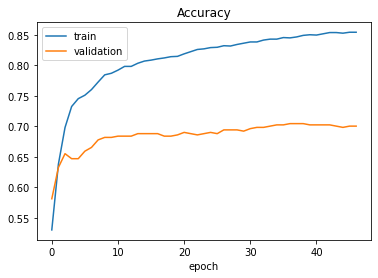

In [18]:
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
%matplotlib inline
# Loss
plt.plot(hist.history['accuracy'], label="train")
plt.plot(hist.history["val_accuracy"], label="validation")
plt.legend()
plt.xlabel('epoch')
plt.title("Accuracy")
plt.show()

In [47]:
model.evaluate(x_test.A, y_test, verbose=0)

[-28.27454376220703, 0.27914613485336304]

In [50]:
model.predict(x_test.A)

20/20 [==============================] - 0s 948us/step


array([[ 1.3316696 ],
       [ 8.052009  ],
       [ 1.1612129 ],
       [ 5.5336885 ],
       [ 4.2770863 ],
       [ 7.4174595 ],
       [ 6.9996376 ],
       [ 3.1264834 ],
       [ 2.7778904 ],
       [ 3.3699763 ],
       [ 2.1601272 ],
       [ 0.42257398],
       [ 3.3119113 ],
       [ 1.9912822 ],
       [ 0.9860979 ],
       [ 0.88137907],
       [ 0.3248542 ],
       [13.322405  ],
       [ 2.0350978 ],
       [ 0.9860979 ],
       [ 2.3465176 ],
       [ 0.55510885],
       [ 1.9700963 ],
       [ 0.66730994],
       [ 1.700707  ],
       [ 7.911809  ],
       [ 3.299201  ],
       [ 3.2622805 ],
       [ 6.2259045 ],
       [ 4.242889  ],
       [ 1.0641465 ],
       [ 0.94825435],
       [ 7.2754416 ],
       [ 1.9473205 ],
       [ 0.66098833],
       [ 1.5337443 ],
       [ 0.84835535],
       [ 1.3835316 ],
       [ 1.2771139 ],
       [ 1.6186984 ],
       [ 1.061579  ],
       [ 2.3695042 ],
       [ 1.8558669 ],
       [ 1.7282457 ],
       [ 1.4501858 ],
       [ 2

In [ ]:
weights, _ = model.trainable_weights

In [ ]:
#import pandas as pd
token_weight = pd.DataFrame({'토큰': cv.get_feature_names(), '가중치': weights.numpy().flat})

In [ ]:
for i in naver.comment:
  if '앞' in i:
    print(i)

In [ ]:
token_weight.sort_values('가중치').head(10)

In [ ]:
token_weight.sort_values('가중치').tail(10)

In [ ]:
for i in range(len(daum.comment)):
  if '내구' in daum.comment[i]:
    print(i, daum.comment[i])

In [20]:
dtm_naver = cv.fit_transform(naver.loc[:,'comment'])

In [21]:
(model.predict(dtm_naver.A).flatten()>=0.5).sum()#.apply(lambda x: 1 if x>=0.5 else 0)

2187

In [ ]:
naver['predict'] = model.predict(dtm_naver.A).flatten()
naver.predict = naver.predict.apply(lambda x: 1 if x>0.5 else 0)

In [ ]:
Maker = ['KIA', 'HYUNDAI', 'GENESIS', 'SSANGYONG', 'SAMSUNG']
KIA = naver.query('maker == @Maker[0]')
HYUNDAI = naver.query('maker == @Maker[1]')
GENESIS = naver.query('maker == @Maker[2]')
SSANGYONG = naver.query('maker == @Maker[3]')
SAMSUNG = naver.query('maker == @Maker[4]')

In [ ]:
for m in urls:
  print(m[1])

In [ ]:
urls

In [ ]:
#댓글이 차에 대한 리뷰인지 맞으면 use 1 아니면 0
#읽어보면서 이번 프로젝트 의도와 맞지 않는 댓글은 제외하였다.
daum_use = pd.read_csv('daum_use.csv',encoding='cp949')
daum = daum_use.query('use == 1')
naver_use = pd.read_csv('naver_use.csv',encoding='cp949')
naver = naver_use.query('use == 1')

In [ ]:
kiwi = Kiwi()
kiwi.prepare()
def extract_keywords(text):
    stopwords = ['을', '를', '이', '가', '은', '는', '히','거','걸','경','그거','그것','그러','글','기','끼','르','마','솔','슬','즈']
    words = []
    result = kiwi.analyze(text)
    for token, pos, _,_ in result[0][0]:
        if pos[0] in 'NVI':
            if token not in stopwords:
                words.append(token)
            #words = [t for t in token if t not in stopwords]
            #words.append(token)
    return words

In [ ]:
max_features = 1500
batch_size = 128
learning_rate = 0.001
epochs = 300

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=max_features, tokenizer=extract_keywords)
dtm = cv.fit_transform(daum.loc[0:, 'comment'])

x=dtm
y=daum.label.values[:]

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [ ]:
# 매번 모델링을 할 때마다 동일한 결과를 얻으려면 아래 코드를 실행해야 함.
# 지난학기 머신러닝 코드
import os
import numpy as np
import random
import tensorflow as tf

def reset_seeds(reset_graph_with_backend=None):
    if reset_graph_with_backend is not None:
        K = reset_graph_with_backend
        K.clear_session()
        tf.compat.v1.reset_default_graph()
        print("KERAS AND TENSORFLOW GRAPHS RESET")  # optional

    np.random.seed(1)
    random.seed(2)
    tf.compat.v1.set_random_seed(3)
    os.environ['CUDA_VISIBLE_DEVICES'] = ''  # for GPU
    print("RANDOM SEEDS RESET")  # optional
   
reset_seeds()

In [ ]:
x_train.shape , x_test.shape

In [ ]:
model = tf.keras.models.Sequential()
model.add(
    tf.keras.layers.Dense(
        1, 
        input_shape=(max_features,), 
        activation='sigmoid',
        #kernel_regularizer=tf.keras.regularizers.l2(0.001))
        ))


In [ ]:
model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

hist = model.fit(x_train.A, y_train, epochs=epochs, validation_split=0.2,
          callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)])

import matplotlib.pylab as plt
from matplotlib import font_manager, rc
%matplotlib inline
# Loss
plt.plot(hist.history['accuracy'], label="train")
plt.plot(hist.history["val_accuracy"], label="validation")
plt.legend()
plt.xlabel('epoch')
plt.title("Accuracy")
plt.show()

model.evaluate(x_test.A, y_test, verbose=0)

weights, _ = model.trainable_weights

import pandas as pd
token_weight = pd.DataFrame({'토큰': cv.get_feature_names(), '가중치': weights.numpy().flat})

token_weight.sort_values('가중치').head(20)

token_weight.sort_values('가중치').tail(20)

naver_use[naver_use.comment=='단점총정리 콘솔박스 폭이 작다(콘솔박스가 작다는건 실내가 작다는거) 컨트롤 패널 조작성능이 불편하다(오디오 볼륨조절 다이얼로 좀 바꿔줫으면 열선시트 쿨링시트 스위치 분리좀해줬으면) 차선이탈보조 장치이지 차선유지보조 장치는 아니다(자율보조주행 아닙니다) B필러 때문에 2열 승하차가 불편하다(발이 계속 걸린다) 2열 높이가 낮아 180이상은 머리가 스치고 183이상은 똑바로 앉아 있지 못하다(시승차에 썬루프가 없는 이유이기도 하다) 배기량에 비해 큰 차급으로 오르막길 출발시 버거움을 느끼는건 어쩔수 없다 트렁크가 높아 유리가 작아져 뒷공간 시야확보가 힘들다(탑차타는거 같은 답답함) 디자인상 어쩔 수 없는 5도어 트렁크라 한계점이 있다 2열 송풍구 너무 아날로그 적(쌍용도 이딴식으로 안만든다)이다 2열 의자 폭이 좁아 허벅지가 뜬다(어째든 큰신장은 2열 너무불편하다) - 단점을 잘 아시고 잘 고려해보신 후 구매하세요']

(model.predict(dtm_naver.A).flatten()>0.5).sum()

model.predict(dtm_naver.A).flatten()[5025]

In [ ]:
naver_use.comment[5372]

In [ ]:
naver_use.iloc[5372, 2]